# Testing new method for blob location determination

- Find initial blob position with djikstra
- Then use a large radius (50-60mm), find the most energetic voxel within it
- Then set this to the centre, and calculate the blob energy with a smaller radius around it (~40mm)

### Lets make a track that fits the description

In [1]:
import sys,os,os.path
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import numpy as np
import pandas as pd

from invisible_cities.cities.components import track_blob_info_creator_extractor
from invisible_cities.io.hits_io        import load_hits
from invisible_cities.io.hits_io        import hits_from_df
from invisible_cities.core              import system_of_units as units
from invisible_cities.types.symbols     import HitEnergy
from invisible_cities.evm.event_model   import HitCollection
from invisible_cities.evm.event_model   import Cluster
from invisible_cities.evm.event_model   import Hit
from invisible_cities.types.ic_types    import xy
from invisible_cities.reco.paolina_functions import voxelize_hits
import invisible_cities.reco.paolina_functions as plf

from   matplotlib.animation import FuncAnimation
import matplotlib.pyplot    as     plt
import matplotlib.colors    as     colors
import matplotlib.cm        as     cm
from matplotlib.colors import Normalize

In [2]:
def plot_voxels(df, base_vsize = 12):

    xs = df.X
    ys = df.Y
    zs = df.Z
    es = df.E

    the_hits = []
    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)
    
    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)
    
    vsizex = voxels[0].size[0]
    vsizey = voxels[0].size[1]
    vsizez = voxels[0].size[2]

    min_corner_x = min(v.X for v in voxels) - vsizex/2.
    min_corner_y = min(v.Y for v in voxels) - vsizey/2.
    min_corner_z = min(v.Z for v in voxels) - vsizez/2.

    
    x = [np.round(v.X/vsizex) for v in voxels]
    y = [np.round(v.Y/vsizey) for v in voxels]
    z = [np.round(v.Z/vsizez) for v in voxels]
    e = [v.E for v in voxels]

    x_min = int(min(x))
    y_min = int(min(y))
    z_min = int(min(z))

    x_max = int(max(x))
    y_max = int(max(y))
    z_max = int(max(z))

    VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
    #print(VOXELS.shape)

    # sort through the event set the "turn on" the hit voxels
    cmap = cm.viridis
    norm = Normalize(vmin=0, vmax=max(e))

    colors = np.empty(VOXELS.shape, dtype=object)
    for q in range(0,len(z)):
        VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
        colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

    # and plot everything
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    #a,b,c is spacing in mm needs an extra dim
    a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
    a = a*vsizex + min_corner_x
    b = b*vsizey + min_corner_y
    c = c*vsizez + min_corner_z

    # a, b, c are the corners of the voxels
    ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

    ax.set_xlabel('x (mm)')#,fontsize=16)
    ax.set_ylabel('y (mm)')#,fontsize=16)
    ax.set_zlabel('z (mm)')#,fontsize=16)


    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax)
    cb.set_label('Energy (keV)')

    fig.suptitle('voxelised_plot_two_tracks')

    #ax.view_init(-160, 90)

    #plt.show(fig)

def raw_plotter(q, evt, pitch = 15.55):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle("rebinned in Z")
    plt.show(fig)



In [3]:
# make a track (it'll need to be much bigger than this obviously)
tr_1 = []
#for i in range(0, 5):
#    z_1 = np.random.uniform(low = 1 * units.mm, high = 20 * units.mm)
#    z_2 = np.random.uniform(low = 1 * units.mm, high = 20 * units.mm)
#    e_1 = np.random.uniform(low = 1, high = 20)
#    e_2 = np.random.uniform(low = 1, high = 20)
#    tr_1.append([0, 1, (9 * i + 1) * units.mm, 0 * units.mm, z_1, 1, e_1, e_1])
#    tr_1.append([0, 1, (9 * i + 1) * units.mm + 1, 30 * units.mm, z_2, 1, e_2, e_2])

# make a really explicit blob
# Create a spherical blob centered at (50, 50, 50) with radius 10 mm
center_x, center_y, center_z = 50 * units.mm, 50 * units.mm, 50 * units.mm
radius = 50 * units.mm
step = 10
# Create a tail for the blob
tail_length = 40  # Number of points in the tail
tail_direction = np.array([0.57735027, 0.57735027, 0.57735027])  # Unit vector for tail direction
tail_start = np.array([center_x, center_y, center_z]) + tail_direction * radius

for i in range(tail_length):
    perturbation = np.random.uniform(-0.5, 0.5, size=3) * units.mm  # Add some randomness to the tail
    current_position = tail_start + i * step * tail_direction + perturbation
    current_position[2] = np.round(current_position[2])  # Make Z position discrete
    energy = np.random.uniform(low=5, high=20)  # Random energy values for tail points
    tr_1.append([0, 1, current_position[0], current_position[1], current_position[2], 1, energy, energy])



for _ in range(500): 
    while True:
        x = np.random.uniform(center_x - radius, center_x + radius)
        y = np.random.uniform(center_y - radius, center_y + radius)
        z = np.random.uniform(center_z - radius, center_z + radius)
        z = np.round(z)  # Make Z position discrete
        distance_to_center = np.sqrt((x - center_x)**2 + (y - center_y)**2 + (z - center_z)**2)
        if distance_to_center <= radius:
            # Make points closer to the center more energetic with a smooth transition
            e = np.random.uniform(low=50, high=100) * (1 - distance_to_center / radius) + \
                np.random.uniform(low=5, high=50) * (distance_to_center / radius)
            tr_1.append([0, 1, x, y, z, 1, e, e])
            break

data = pd.DataFrame(tr_1, columns=['event', 'npeak', 'X', 'Y', 'Z', 'Q', 'E', 'Ep'])

display(data)

,event,npeak,X,Y,Z,Q,E,Ep
0,0,1,79.095165,79.181035,79.0,1,18.127989,18.127989
1,0,1,84.749140,84.889112,84.0,1,6.923999,6.923999
2,0,1,90.749400,89.994539,91.0,1,11.470307,11.470307
3,0,1,96.176949,96.317691,97.0,1,13.104688,13.104688
4,0,1,101.534359,101.516023,102.0,1,12.328292,12.328292
...,...,...,...,...,...,...,...,...
535,0,1,71.709278,27.538531,51.0,1,44.119723,44.119723
536,0,1,34.913303,22.025250,12.0,1,44.280159,44.280159
537,0,1,20.932744,32.256138,85.0,1,41.781787,41.781787
538,0,1,52.576472,95.725007,59.0,1,11.026566,11.026566


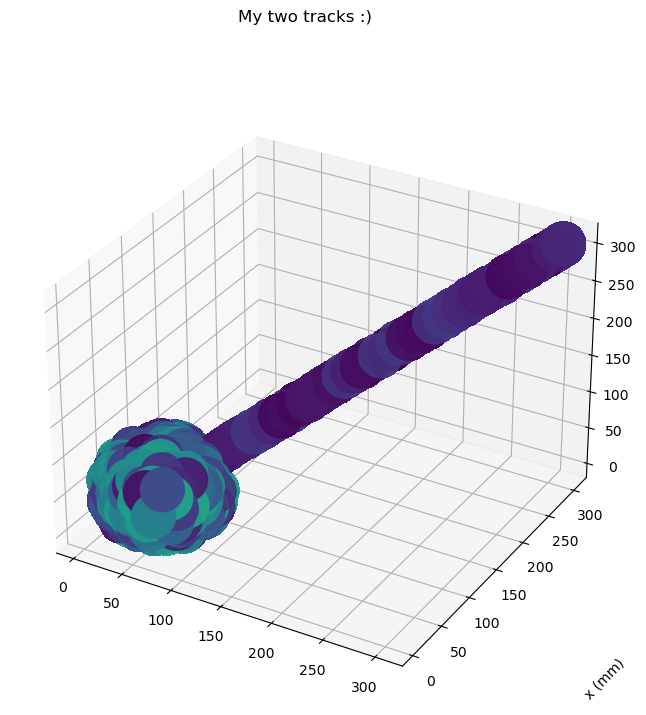

In [4]:
plt.ion()
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
for Y, df in data.groupby(['Y']):
    ax.scatter(data.X, data.Y, data.Z, c=data.E, s=1000, label = f'{Y}')
ax.set_xlabel("z (mm)", labelpad=50)
ax.set_ylabel("x (mm)", labelpad=50)
ax.set_zlabel("y (mm)", labelpad=50)
plt.suptitle("My two tracks :)")

plt.show()

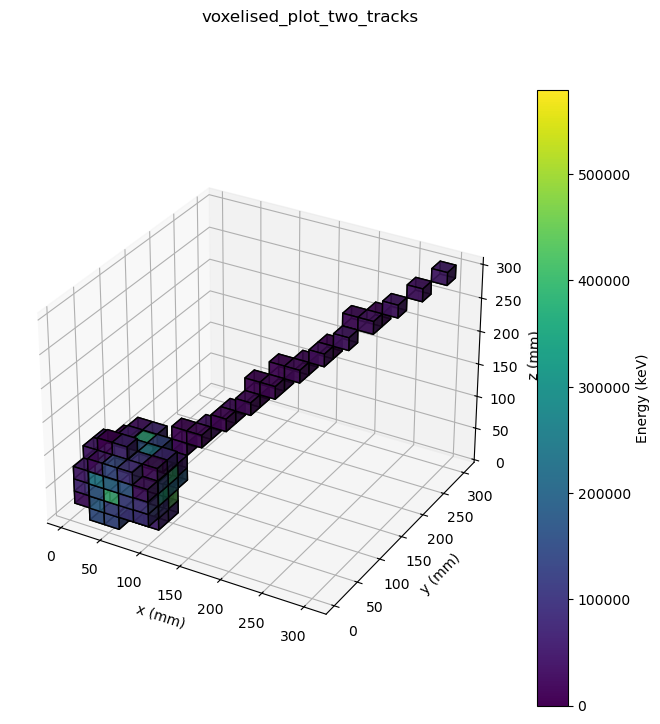

In [5]:
plot_voxels(data, base_vsize = 20)

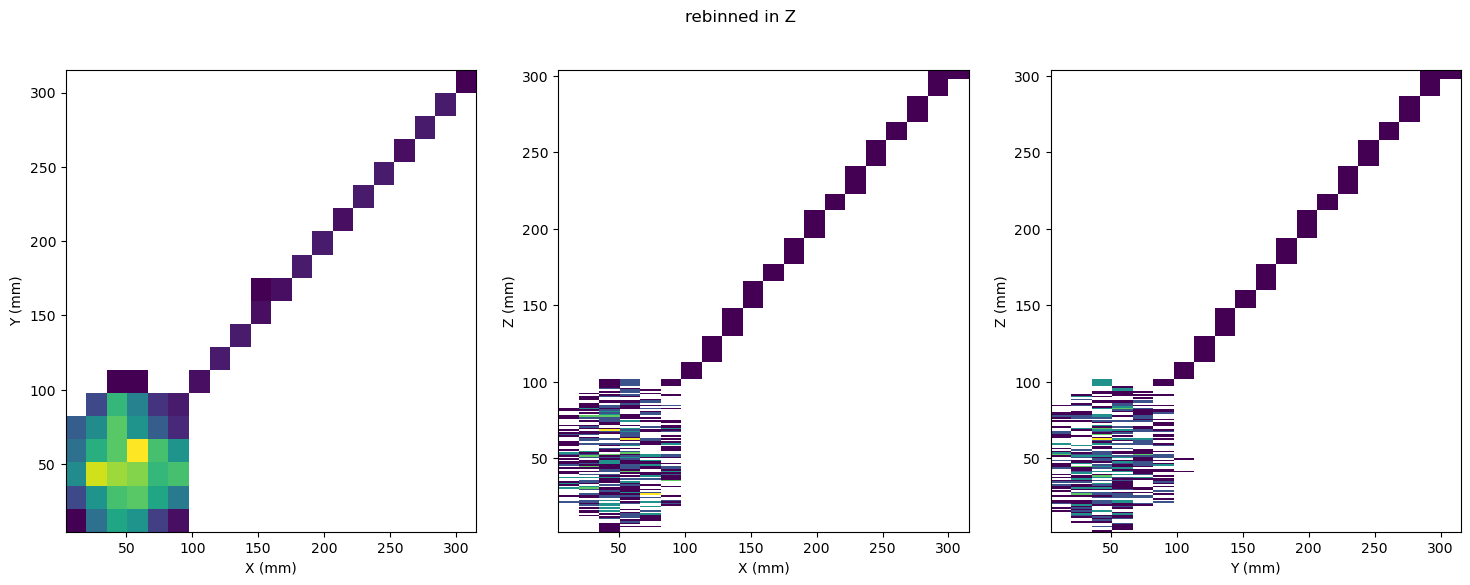

In [6]:
raw_plotter(data, 0)

## We have the blob now, lets show the current radius calculation method

In [7]:
scan_radius = 75 * units.mm
blob_radius = 50 * units.mm

topological_creator = track_blob_info_creator_extractor((12 * units.mm, 12 * units.mm, 12 * units.mm),
                                                        False,
                                                        10 * units.keV,
                                                        3,
                                                        blob_radius,
                                                        1000000
                                                        )

In [8]:
hits_lol = hits_from_df(data)

df, track_hitc, out_of_map = topological_creator(hits_lol[0])
display(df)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,19841.248683,492.013368,327,540,1,4.208599,4.413199,2.0,...,12.0,301.572925,301.128299,301.170916,6571.971971,71.704791,0.0,11.538553,11.970006,11.615385


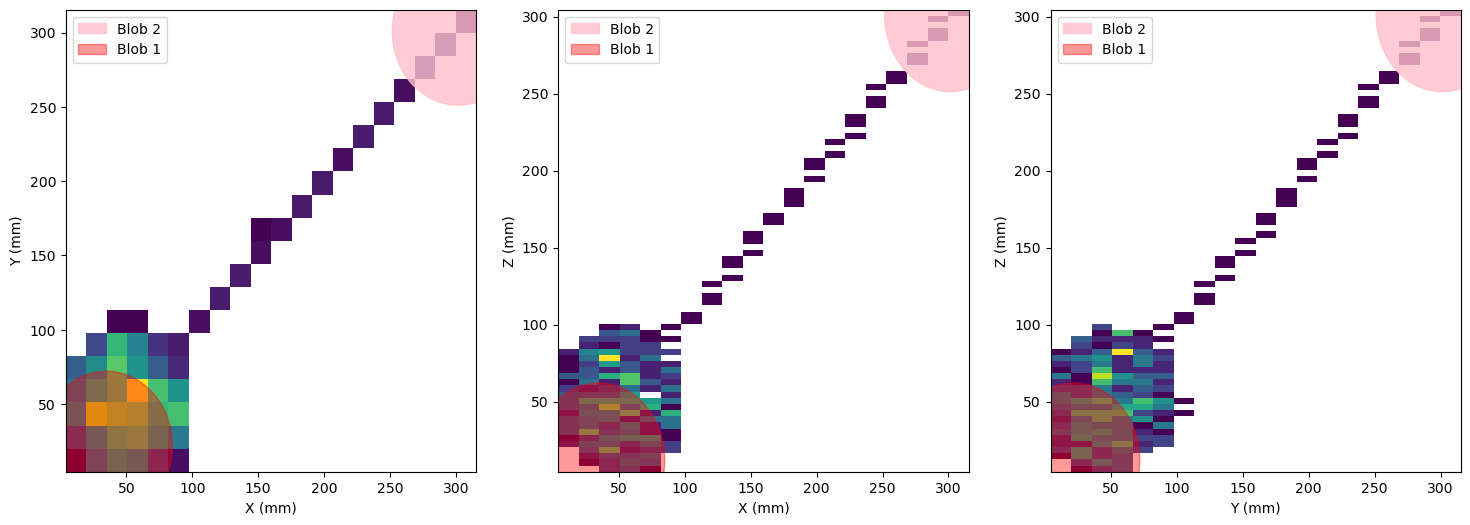

In [9]:
from matplotlib.patches import Circle

q = data
pitch = 15.55
z_pitch = 4 # to deal with plotting


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.arange(q.Y.min(), q.Y.max() + z_pitch, z_pitch)

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

x_b1 = df.blob1_x
y_b1 = df.blob1_y
z_b1 = df.blob1_z

x_b2 = df.blob2_x
y_b2 = df.blob2_y
z_b2 = df.blob2_z
for ax, (x_data, y_data) in zip(axes, [(x_b2, y_b2), (x_b2, z_b2), (y_b2, z_b2)]):
    for x, y in zip(x_data, y_data):
        circle = Circle((x, y), radius=blob_radius, color='pink', alpha=0.8, label='Blob 2')
        ax.add_patch(circle)
    ax.legend()

for ax, (x_data, y_data) in zip(axes, [(x_b1, y_b1), (x_b1, z_b1), (y_b1, z_b1)]):
    for x, y in zip(x_data, y_data):
        circle = Circle((x, y), radius=blob_radius, color='red', alpha=0.4, label='Blob 1')
        ax.add_patch(circle)
    ax.legend()


In [10]:
from invisible_cities.reco                      import         paolina_functions as plf
from typing import Tuple, Callable, Sequence
from invisible_cities.core.system_of_units import mm
from invisible_cities.types.ic_types import types_dict_tracks
from invisible_cities.evm.event_model import BHit, Voxel
from networkx           import Graph

def find_highest_energy_node( track: Graph
                            , extreme : Voxel
                            , radius  : float) -> Tuple[Voxel, dict]:
    """Find the node with the highest associated energy in the track graph"""
    # we want to obtain the node information here, so have to flag data = True
    # and take first element
    # (energy information is encoded into node, for some reason)
    distances         = plf.shortest_paths(track)

    nodes_within_radius = [node for node in track.nodes if distances[extreme][node] <= radius]
    highest_energy_node = max(nodes_within_radius, key=lambda node: node.E)
    print(highest_energy_node)
    return highest_energy_node

def find_highest_encapsulating_node( track   : Graph
                                   , extreme : Voxel
                                   , big_radius    : float
                                   , small_radius  : float) -> Tuple[Voxel, dict]:
    '''
    Find the voxel within a big radius for which the most energy
    is captured within an equivalent smaller radius.
    '''
    distances = plf.shortest_paths(track)
    nodes_within_radius = [node for node in track.nodes if distances[extreme][node] <= big_radius]

    def energy_within_radius(node):
        return plf.energy_of_voxels_within_radius(distances[node], radius)

    highest_encapsulating_node = max(nodes_within_radius, key=energy_within_radius)
    return highest_encapsulating_node


def blob_energies_hits_and_centres_altered( track_graph  : Graph
                                          , big_radius   : float
                                          , small_radius : float) -> Tuple[float, float, Sequence[BHit], Sequence[BHit], Tuple[float, float, float], Tuple[float, float, float]]:
    """Return the energies, the hits and the positions of the blobs.
       Does so with a double iteration method, first taking the extremes
       and defining an extreme radius around them to find the voxel with the
       largest energy, and redefining that as the central voxel.
       """
    distances = plf.shortest_paths(track_graph)
    a, b, _   = plf.find_extrema_and_length(distances)

    # find the highest energy voxel in a radius
    #va_highE = find_highest_energy_node(track_graph, a, big_radius)
    #vb_highE = find_highest_energy_node(track_graph, b, big_radius)
    va_highE = find_highest_encapsulating_node(track_graph, a, big_radius, small_radius)
    vb_highE = find_highest_encapsulating_node(track_graph, b, big_radius, small_radius)
    # Select any node and check its attributes
    ha = plf.hits_in_blob(track_graph, small_radius, va_highE)
    hb = plf.hits_in_blob(track_graph, small_radius, vb_highE)

    voxels = list(track_graph.nodes())
    e_type = voxels[0].Etype
    Ea = sum(getattr(h, e_type) for h in ha)
    Eb = sum(getattr(h, e_type) for h in hb)

    # Consider the case where voxels are built without associated hits
    if len(ha) == 0 and len(hb) == 0 :
        Ea = plf.energy_of_voxels_within_radius(distances[va_highE], small_radius)
        Eb = plf.energy_of_voxels_within_radius(distances[vb_highE], small_radius)

    ca = plf.blob_centre(va_highE)
    cb = plf.blob_centre(vb_highE)

    if Eb > Ea:
        return (Eb, Ea, hb, ha, cb, ca)
    else:
        return (Ea, Eb, ha, hb, ca, cb)


# now lets think up the new functionality for determining the blob centre
def track_blob_info_creator_extractor_altered(vox_size         : Tuple[float, float, float],
                                      strict_vox_size  : bool                      ,
                                      energy_threshold : float                     ,
                                      min_voxels       : int                       ,
                                      scan_radius      : float                     ,
                                      blob_radius      : float                     ,
                                      max_num_hits     : int
                                     ) -> Callable:
    """
    For a given paolina parameters returns a function that extract tracks / blob information from a HitCollection.

    Parameters
    ----------
    vox_size         : [float, float, float]
        (maximum) size of voxels for track reconstruction
    strict_vox_size  : bool
        if False allows per event adaptive voxel size,
        smaller of equal thatn vox_size
    energy_threshold : float
        if energy of end-point voxel is smaller
        the voxel will be dropped and energy redistributed to the neighbours
    min_voxels       : int
        after min_voxel number of voxels is reached no dropping will happen.
    blob_radius      : float
        radius of blob

    Returns
    ----------
    A function that from a given HitCollection returns a pandas DataFrame with per track information.
    """
    def create_extract_track_blob_info(hitc):
        df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
        if len(hitc.hits) > max_num_hits:
            return df, hitc, True
        #track_hits is a new Hitcollection object that contains hits belonging to tracks, and hits that couldnt be corrected
        track_hitc = HitCollection(hitc.event, hitc.time)
        out_of_map = np.any(np.isnan([h.Ep for h in hitc.hits]))
        if out_of_map:
            #add nan hits to track_hits, the track_id will be -1
            track_hitc.hits.extend  ([h for h in hitc.hits if np.isnan   (h.Ep)])
            hits_without_nan       = [h for h in hitc.hits if np.isfinite(h.Ep)]
            #create new Hitcollection object but keep the name hitc
            hitc      = HitCollection(hitc.event, hitc.time)
            hitc.hits = hits_without_nan

        hit_energies = np.array([getattr(h, HitEnergy.Ep.value) for h in hitc.hits])

        if len(hitc.hits) > 0 and (hit_energies>0).any():
            voxels           = plf.voxelize_hits(hitc.hits, vox_size, strict_vox_size, HitEnergy.Ep)
            (    mod_voxels,
             dropped_voxels) = plf.drop_end_point_voxels(voxels, energy_threshold, min_voxels)

            for v in dropped_voxels:
                track_hitc.hits.extend(v.hits)

            tracks = plf.make_track_graphs(mod_voxels)
            tracks = sorted(tracks, key=plf.get_track_energy, reverse=True)

            vox_size_x = voxels[0].size[0]
            vox_size_y = voxels[0].size[1]
            vox_size_z = voxels[0].size[2]
            del(voxels)

            track_hits = []
            for c, t in enumerate(tracks, 0):
                tID = c
                energy = plf.get_track_energy(t)
                numb_of_hits   = len([h for vox in t.nodes() for h in vox.hits])
                numb_of_voxels = len(t.nodes())
                numb_of_tracks = len(tracks   )
                pos   = [h.pos for v in t.nodes() for h in v.hits]
                x, y, z = map(np.array, zip(*pos))
                r = np.sqrt(x**2 + y**2)

                e     = [h.Ep for v in t.nodes() for h in v.hits]
                ave_pos = np.average(pos, weights=e, axis=0)
                ave_r   = np.average(r  , weights=e, axis=0)
                distances = plf.shortest_paths(t)
                extr1, extr2, length = plf.find_extrema_and_length(distances)
                extr1_pos = extr1.XYZ
                extr2_pos = extr2.XYZ

                e_blob1, e_blob2, hits_blob1, hits_blob2, blob_pos1, blob_pos2 = blob_energies_hits_and_centres_altered(t, scan_radius, blob_radius)

                overlap = float(sum(h.Ep for h in set(hits_blob1).intersection(set(hits_blob2))))
                list_of_vars = [hitc.event, tID, energy, length, numb_of_voxels,
                                numb_of_hits, numb_of_tracks,
                                min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r),
                                *ave_pos, ave_r, *extr1_pos,
                                *extr2_pos, *blob_pos1, *blob_pos2,
                                e_blob1, e_blob2, overlap,
                                vox_size_x, vox_size_y, vox_size_z]

                df.loc[c] = list_of_vars

                for vox in t.nodes():
                    for hit in vox.hits:
                        hit.track_id = tID
                        track_hits.append(hit)

            #change dtype of columns to match type of variables
            df = df.apply(lambda x : x.astype(types_dict_tracks[x.name]))
            track_hitc.hits.extend(track_hits)
        return df, track_hitc, out_of_map

    return create_extract_track_blob_info

In [11]:

topological_creator = track_blob_info_creator_extractor_altered((12 * units.mm, 12 * units.mm, 12 * units.mm),
                                                        False,
                                                        10 * units.keV,
                                                        3,
                                                        scan_radius,
                                                        blob_radius,
                                                        1000000
                                                        )

In [12]:
hits_lol = hits_from_df(data)

df, track_hitc, out_of_map = topological_creator(hits_lol[0])
display(df)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,19841.248683,492.013368,327,540,1,4.208599,4.413199,2.0,...,39.737104,274.887927,275.423422,275.0,16642.953995,129.786909,0.0,11.538553,11.970006,11.615385


(0.0, 350.0)

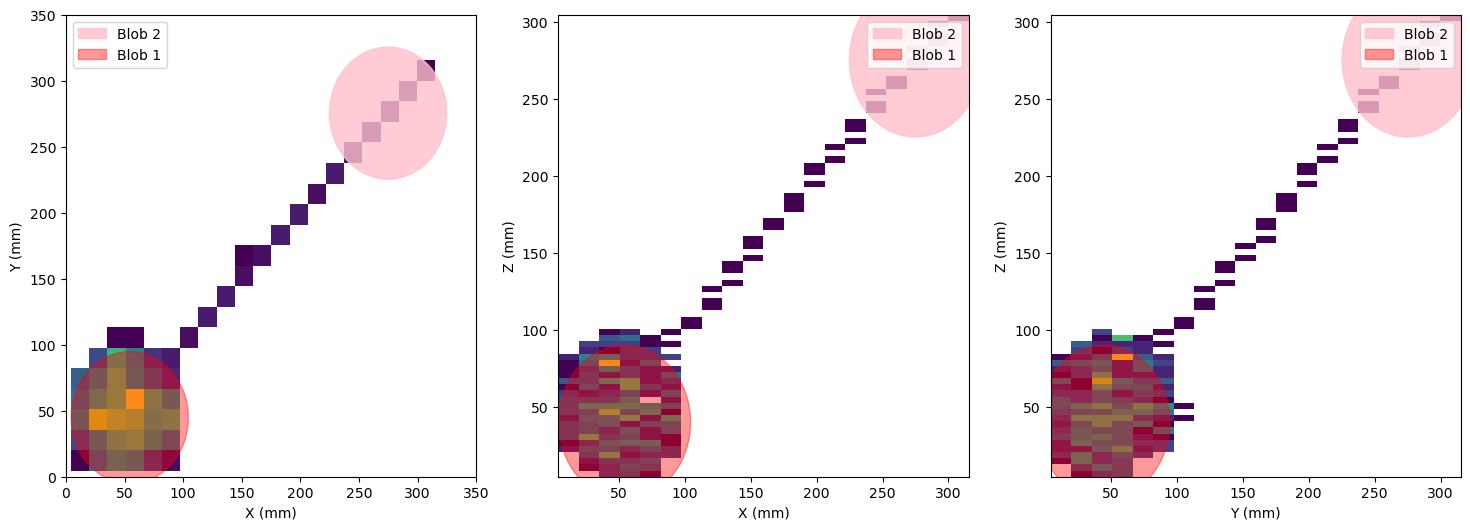

In [13]:
from matplotlib.patches import Circle

q = data
pitch = 15.55
z_pitch = 4 # to deal with plotting


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.arange(q.Y.min(), q.Y.max() + z_pitch, z_pitch)

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

x_b1 = df.blob1_x
y_b1 = df.blob1_y
z_b1 = df.blob1_z

x_b2 = df.blob2_x
y_b2 = df.blob2_y
z_b2 = df.blob2_z
for ax, (x_data, y_data) in zip(axes, [(x_b2, y_b2), (x_b2, z_b2), (y_b2, z_b2)]):
    for x, y in zip(x_data, y_data):
        circle = Circle((x, y), radius=blob_radius, color='pink', alpha=0.8, label='Blob 2')
        ax.add_patch(circle)
    ax.legend()

for ax, (x_data, y_data) in zip(axes, [(x_b1, y_b1), (x_b1, z_b1), (y_b1, z_b1)]):
    for x, y in zip(x_data, y_data):
        circle = Circle((x, y), radius=blob_radius, color='red', alpha=0.4, label='Blob 1')
        ax.add_patch(circle)
    ax.legend()

axes[0].set_xlim(0, 350)
axes[0].set_ylim(0, 350)
